Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 15.  Winter 2026.

In [3]:
import pandas as pd

# SMILES

Simplified Molecular Input Line Entry System (SMILES) are ways to encode molecular structure in text.  Our aqueous solubility data has a SMILES string associated with it, so we'll load that data set to get some SMILES examples.  We'll just grab the first 5 molecules to demonstrate the methods.

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Homework2/solubility_train.csv')

examples = 5

smiles = df['SMILES'][:examples]

print(smiles)

0                   Fc1ccc(Oc2ccnc3cc(Cl)cc(Cl)c23)cc1
1                     CC1=NC(=C(S1)C(=O)NC2=CC=CC=C2)C
2                         Cc1cc(O)c(Cc2ccccc2)c(C)c1Cl
3                                      Cc1ccc(N)c(C)c1
4    COC1=CC=C2C=C(C=CC2=C1)C(C)C(=O)OCC(=O)N(C)CC(...
Name: SMILES, dtype: object


One thing that we can do is use <code>rdkit</code> to visualize these structures.  The library is not in the standard <code>Colab</code> distribution, but we can install it!  Using <code>!pip install</code>, we can tell Colab to download and install this libraries so that we can use it.

In [5]:
!pip install rdkit
import rdkit

We'll convert the strings to structures, filter out any bad structures, and visualize the first few.

Fc1ccc(Oc2ccnc3cc(Cl)cc(Cl)c23)cc1


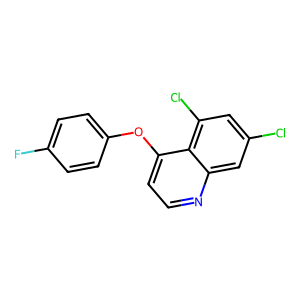




CC1=NC(=C(S1)C(=O)NC2=CC=CC=C2)C


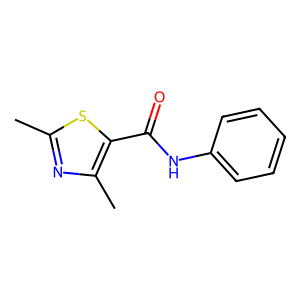




Cc1cc(O)c(Cc2ccccc2)c(C)c1Cl


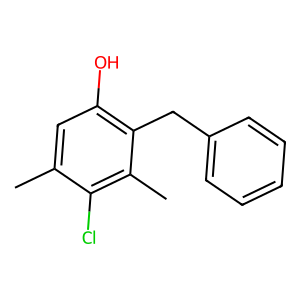




Cc1ccc(N)c(C)c1


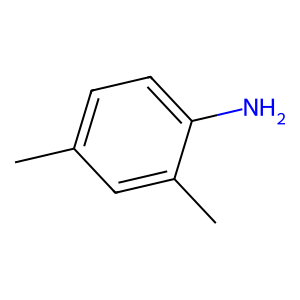




COC1=CC=C2C=C(C=CC2=C1)C(C)C(=O)OCC(=O)N(C)CC(N)=O


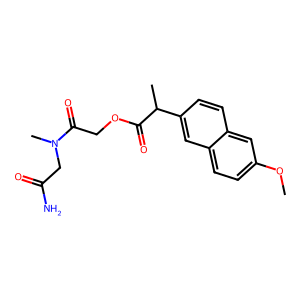

In [6]:
structures = [rdkit.Chem.MolFromSmiles(s) for s in smiles]

#if rdkit can't make a structure it will have a None value
#here we keep structures that are not None
valid_smiles = [sm for sm,st in zip(smiles, structures) if st != None]
valid_structures = [st for st in structures if st != None]

for vsm, vst in zip(valid_smiles, valid_structures):
  print(vsm)
  display(rdkit.Chem.Draw.MolToImage(vst))
  print('\n\n')

You can also just put your own SMILES string in manually to visualize the structure.

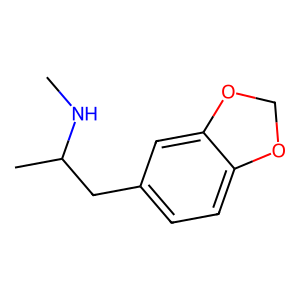

In [7]:
example = rdkit.Chem.MolFromSmiles('O1COc(c2)c1ccc2CC(C)NC')
display(rdkit.Chem.Draw.MolToImage(example))

#Molecular Descriptors

Another useful package is <code>mordred</code>.  This can take a SMILES string and return a vector of numerical descriptors of the molecule.  These numerical descriptors, then, can be used as features for machine learning models.  We'll again have to install <code>mordred</code> first.

In [8]:
!pip install mordredcommunity
import mordred, mordred.descriptors

Let's build our features from the SMILES strings.  Ignore_3D=True means that we won't compute descriptors that require a 3D structure.  We'll only compute descriptors from a SMILES string.  Actually, we'll compute the features from the <code>rdkit</code> structures that we computed from the SMILES strings.


In [9]:
#set up mordred calculator
calculator = mordred.Calculator(mordred.descriptors, ignore_3D=True)

#apply calculator to SMILES strings
features = calculator.pandas(valid_structures)

100%|██████████| 5/5 [00:01<00:00,  4.69it/s]


The resulting descriptors are a <code>pandas</code> dataframe.  Unfortunately, some features include errors and strings and warnings and other non-sensical stuff.  We can remove this by restricting our columns (features) to ones that only contain numerical values.

Then we can look at the column names to see what each of the features are.  We can also count how many features were generated.  We can also take a look at the descriptor values for the first molecule.

In [10]:
cleaned_features = pd.DataFrame(features).select_dtypes(include=['number'])

print(cleaned_features.columns)
print('Number of descriptors: ', len(cleaned_features.columns))

Index(['ABC', 'ABCGG', 'nAcid', 'nBase', 'SpAbs_A', 'SpMax_A', 'SpDiam_A',
       'SpAD_A', 'SpMAD_A', 'LogEE_A',
       ...
       'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1', 'Zagreb2',
       'mZagreb1', 'mZagreb2'],
      dtype='object', length=1394)
Number of descriptors:  1394


From our SMILES string we now have 1378 numerical features for each molecule.  These include the number of acid groups, the number of base groups, the number of armoatic bonds, the number of atoms, the number of heavy (non-hydrogen) atoms, and the molecular weight.

# One Hot Encoding

With one-hot encoding, each unqiue element in your set becomes a vector with all zeros and a single one.  The one is in a different place for each unique element.  The length of this vector is the number of unique elements.  

We're going to revisit the example we used with convolutional and recurrent neural networks.  We used the aqueous solubility data to predict solubility from SMILES strings.  Previously we tokenized- we assigned a unique value to each unique character in our SMILES strings.  Now we'll do one-hot encoding where we assign a unique one-hot vector to each unique character in our SMILES strings.

We'll use a CNN as our model and redo the case where we tokenized.  This will give us a baseline for comparison.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from tqdm.keras import TqdmCallback

In [12]:
#load training and testing data
df_train = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Homework2/solubility_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Homework2/solubility_test.csv')

#filter out long smiles
max_smile_length = 96
mask_train = [len(s) <= max_smile_length for s in df_train['SMILES']]
print('Removed '+str(df_train.shape[0] - sum(mask_train))+' long SMILES strings from training data.')
filtered_training_data = df_train[mask_train]

mask_test = [len(s) <= max_smile_length for s in df_test['SMILES']]
print('Removed '+str(df_test.shape[0] - sum(mask_test))+' long SMILES strings from test data.')
filtered_test_data = df_test[mask_test]

#figure out how many unique characters there are across all the SMILES
all_SMILES = pd.concat([filtered_training_data['SMILES'], filtered_test_data['SMILES']], ignore_index=True)
unique_count = len(set().union(*all_SMILES))+1

#the tokenizer will convert our characters into numbers
#filers='' means we won't filter any characters, every character in the SMILES string counts
#char_level=True means that we'll break the SMILES strings down into individual characters (as opposed to words for natural language processing)
#lower=False means that we distinguish between upper and lower case (lower case means the atom is in an aromatic ring)
tokenizer = tf.keras.preprocessing.text.Tokenizer(unique_count, filters='', char_level=True, lower=False)
tokenizer.fit_on_texts(all_SMILES)

#we now convert our training and test SMILES to integer sequences with the tokenizer
train_seqs = tokenizer.texts_to_sequences(filtered_training_data['SMILES'])
test_seqs = tokenizer.texts_to_sequences(filtered_test_data['SMILES'])

#finally, we pad our sequences with zeros at the end so each is the same length
padded_train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
padded_test_seqs = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

#build the training and test targets
y_train = filtered_training_data["Solubility"].values
y_test = filtered_test_data["Solubility"].values

Removed 257 long SMILES strings from training data.
Removed 28 long SMILES strings from test data.


In [13]:
def graphs_and_analysis(model, history, X_train, X_test, y_train, y_test, title):
  #make predictions on the training and test data
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  #calculate the MSE on the training and test data
  mse_train = sklearn.metrics.mean_squared_error(y_pred_train, y_train)
  mse_test = sklearn.metrics.mean_squared_error(y_pred_test, y_test)

  #calculate R^2 on the training and test data
  R2_train = sklearn.metrics.r2_score(y_train, y_pred_train)
  R2_test = sklearn.metrics.r2_score(y_test, y_pred_test)

  #set up plots
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))

  #plot the training predictions against actual solubility
  ax[0].scatter(y_train, y_pred_train, color='b', marker='x',label='train')
  ax[0].set_xlabel('actual solubility (log(mol/L))',fontsize=14)
  ax[0].set_ylabel('predicted solubility (log(mol/L))',fontsize=14)
  ax[0].grid()
  ax[0].set_title('training, MSE= '+str(np.round(mse_train,decimals=3))+', R$^2=$ '+str(np.round(R2_train,decimals=3)),fontsize=16)

  #plot the test predictions against the actual solubility
  ax[1].scatter(y_test, y_pred_test, color='orange', marker='o',label='test')
  ax[1].set_xlabel('actual solubility (log(mol/L))',fontsize=14)
  ax[1].set_ylabel('predicted solubility (log(mol/L))',fontsize=14)
  ax[1].grid()
  ax[1].set_title('testing, MSE= '+str(np.round(mse_test, decimals=3))+', R$^2=$ '+str(np.round(R2_test, decimals=3)),fontsize=16)
  fig.suptitle(title, fontsize=20)
  plt.tight_layout()


  fgi2, ax2 = plt.subplots(1, 1, figsize=(5, 5))

  ax2.plot(history.history['loss'], label='training', color='r')
  ax2.plot(history.history['val_loss'], label='validation',color='g')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('loss')
  ax2.legend(fontsize=14)
  ax2.grid()

  plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 10)         │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 48, 20)         │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 24, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 24, 30)         │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,771 (38.17 KB)

 Trainable params: 9,771 (38.17 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


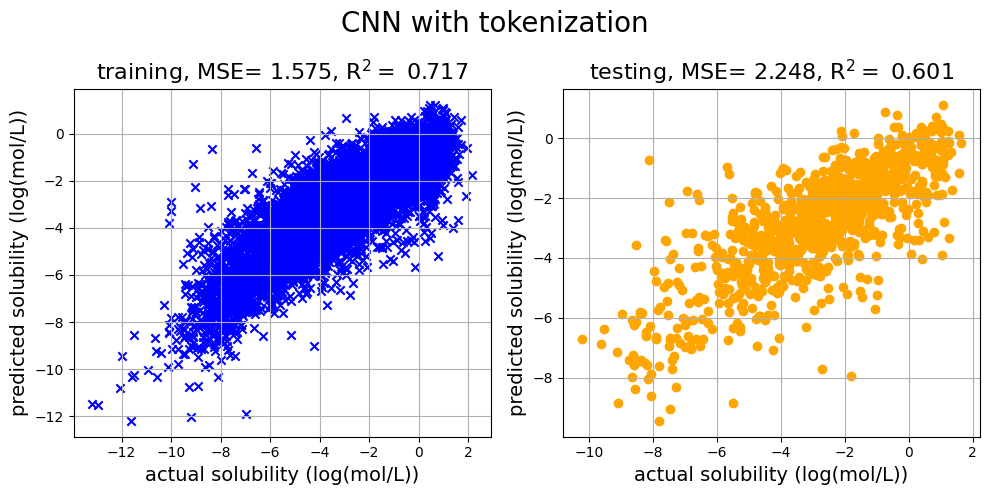

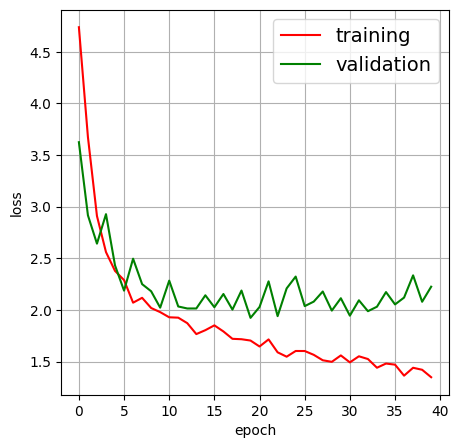

In [14]:
model = keras.models.Sequential([
  keras.layers.Input(shape=(96,1)),
  #keras.layers.Embedding(input_dim=128, output_dim=16, input_length=96),

  keras.layers.Conv1D(filters=10, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=2),

  keras.layers.Conv1D(filters=20, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=2),

  keras.layers.Conv1D(filters=30, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=4),

  keras.layers.Flatten(),
  keras.layers.Dense(40, activation='relu'),

  keras.layers.Dense(1, activation='linear')
])

model.summary()

adm = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=adm, metrics=['mse'])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(padded_train_seqs, y_train, epochs=100, batch_size=50, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(), early_stop])

graphs_and_analysis(model, history, padded_train_seqs, padded_test_seqs, y_train, y_test, 'CNN with tokenization')

Okay, now let's transform our padded feature sequences into a sequence of one-hot vectors with <code>Keras</code>'s <code>to_categorical</code> function.  We'll need to give it the number of unqiue characters found in our SMILES string, which we previously calculated as <code>unique_count</code>.

In [15]:
train_onehot = keras.utils.to_categorical(padded_train_seqs, num_classes=unique_count)
test_onehot = keras.utils.to_categorical(padded_test_seqs, num_classes=unique_count)

Our each molecule will now have a sequence that is 96 characters long (we capped our SMILES strings at this length and padded strings less than this length).  And each character is represented by a one-hot vector that is <code>unique_count</code> characters long.  We previous determined that we had 63 unique characters in our SMILES strings.  With our 8,726 different training molecules, our features are now 8726 $\times$ 96 $\times$ 63.

In [16]:
print(train_onehot.shape) #shape of features
print(train_onehot[0]) #example one-hot encoding for the first molecule

(8726, 96, 64)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


Let's train our CNN on this data.  We'll have to unpdate the input layer size with the one-hot vector dimensions.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 96, 10)         │         1,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 48, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 48, 20)         │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 24, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 24, 30)         │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,661 (45.55 KB)

 Trainable params: 11,661 (45.55 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


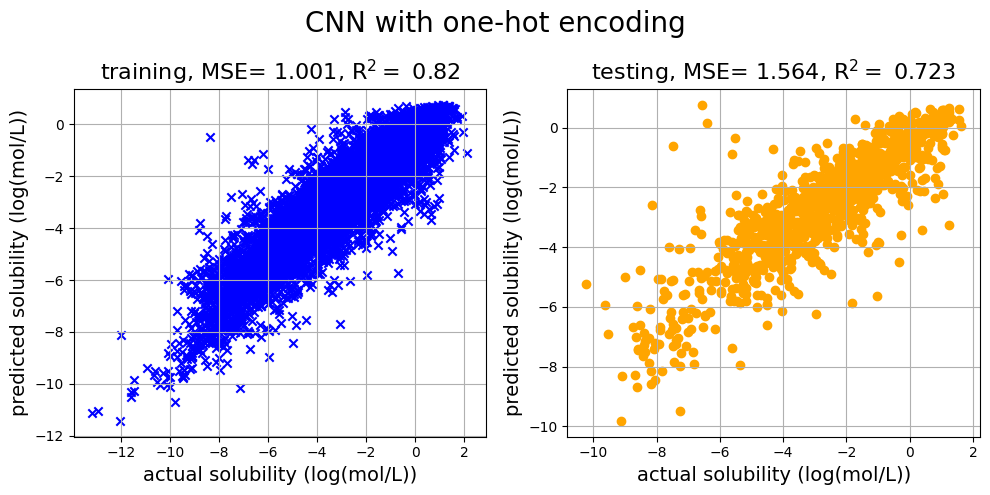

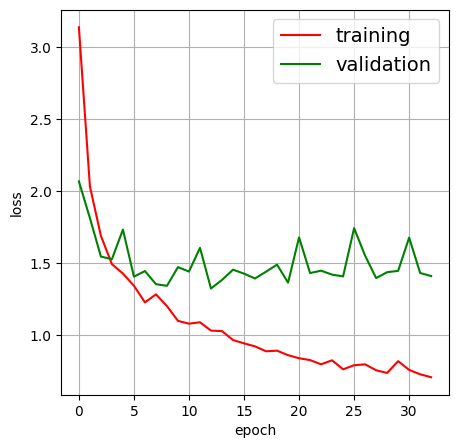

In [17]:
model = keras.models.Sequential([
  keras.layers.Input(shape=(96,unique_count)),
  #keras.layers.Embedding(input_dim=128, output_dim=16, input_length=96),

  keras.layers.Conv1D(filters=10, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=2),

  keras.layers.Conv1D(filters=20, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=2),

  keras.layers.Conv1D(filters=30, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=4),

  keras.layers.Flatten(),
  keras.layers.Dense(40, activation='relu'),

  keras.layers.Dense(1, activation='linear')
])

model.summary()

adm = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=adm, metrics=['mse'])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(train_onehot, y_train, epochs=100, batch_size=50, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(), early_stop])

graphs_and_analysis(model, history, train_onehot, test_onehot, y_train, y_test, 'CNN with one-hot encoding')

That's quite a bit better!

# Embedding

With one-hot encoding we can end up with fairly large inputs if we have large volubularies (numbers of unique characters).  And these inputs are sparse- they have a lot of zeros.  Embedding takes each unique character and represents it in as a lower dimensionsal, but dense vector.  The embeddings are learned during training, so they appear in place of the input layer.  Let's redo our CNN example with embedding.  In the embedding layer we give the unique number of elements (vocabulary size) with <code>input_dim</code>, the number of dimensions in the embedding with <code>output_dim</code>, and the length of the sequences with <code>input_length</code>.  Here we'll chose a 16-dimensional embedding.

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 96, 16)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 96, 10)         │           490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 48, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 48, 20)         │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 24, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 24, 30)         │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 40)             │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,737 (131.79 KB)

 Trainable params: 11,245 (43.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,492 (87.86 KB)

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


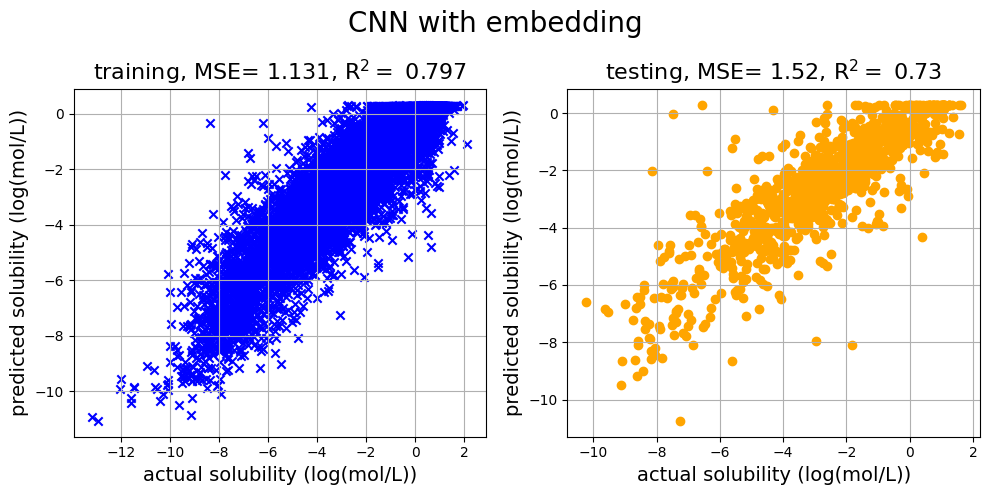

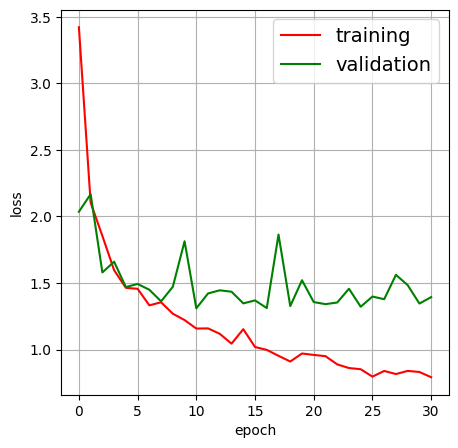

In [18]:
model = keras.models.Sequential([
  keras.layers.Input(shape=(96,)),
  keras.layers.Embedding(input_dim=unique_count, output_dim=16),

  keras.layers.Conv1D(filters=10, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=2),

  keras.layers.Conv1D(filters=20, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=2),

  keras.layers.Conv1D(filters=30, kernel_size=3, activation='relu', padding='same'),
  keras.layers.MaxPooling1D(pool_size=4),

  keras.layers.Flatten(),
  keras.layers.Dense(40, activation='relu'),

  keras.layers.Dense(1, activation='linear')
])

adm = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=adm, metrics=['mse'])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(padded_train_seqs, y_train, epochs=100, batch_size=50, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(), early_stop])

model.summary()

graphs_and_analysis(model, history, padded_train_seqs, padded_test_seqs, y_train, y_test, 'CNN with embedding')

Pretty good!  Just for fun, let's try this with a recurrent neural network.

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 96, 16)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50)             │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,477 (162.02 KB)

 Trainable params: 13,825 (54.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,652 (108.02 KB)

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


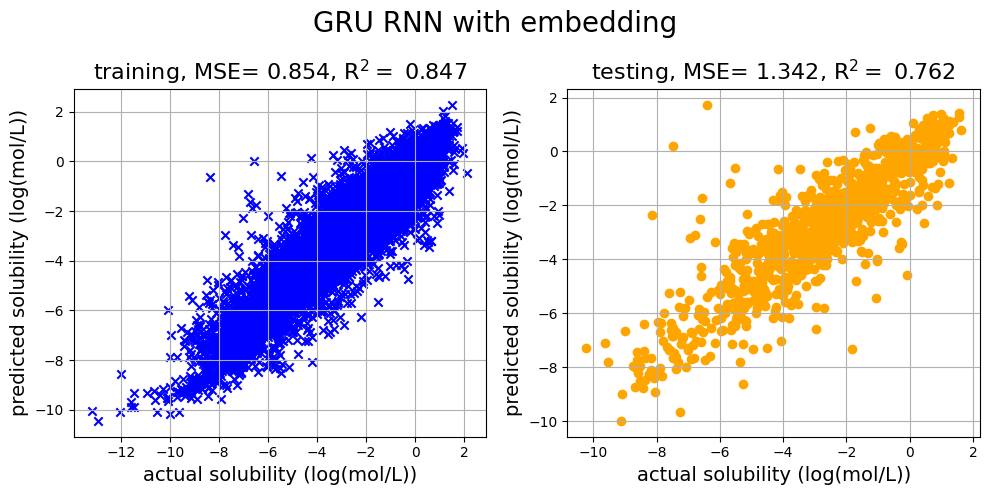

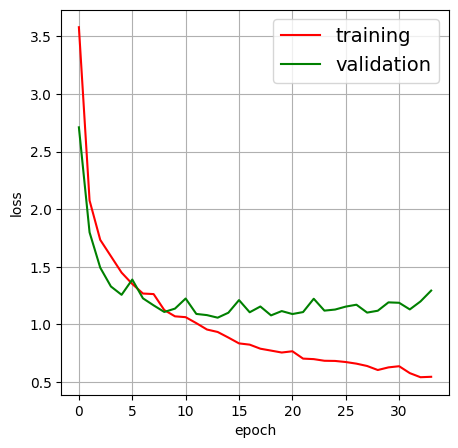

In [19]:
model = keras.models.Sequential([
  keras.layers.Input(shape=(96,)),
  keras.layers.Embedding(input_dim=unique_count, output_dim=16, mask_zero=True),#take advantage of mask_zero=True, which explicitly ignores the zero-padding in the input sequences
  keras.layers.GRU(50, return_sequences=False),#the default activation functions are activation='tanh' and recurrent_activation='sigmoid'
  keras.layers.Dense(50, activation='relu'),
  keras.layers.Dense(1, activation='linear')
])

adm = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mse', optimizer=adm, metrics=['mse'])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(padded_train_seqs, y_train, epochs=100, batch_size=50, validation_split=0.2, verbose=0, callbacks=[TqdmCallback(), early_stop])

model.summary()

graphs_and_analysis(model, history, padded_train_seqs, padded_test_seqs, y_train, y_test, 'GRU RNN with embedding')

Very nice, indeed.